# Variance Estimation

We need to look at the best methods for estimating the allowed variance. A few key notes at the moment:

- Look at different ranges (i.e. previous record, 2 records previous, 3 records previous...) to find how the variance changes based on these estimations.
- From meeting: we are also interested in capturing the variance spike when it goes up and comes back down. We don't only mark the spike incorrect, but where it began as well.
- We can look at detecting spikes using the z-score algorithm (i.e. use a running mean and capture when it deviates too far too quickly).
- **ISSUE**: most of this analysis below (normality assumption) work for some stations, but not all; looking at stations 87, *115*, 152, *36*, and 111. The *italicized* station numbers did mostly hold for normal variance distribution, but not as well as the others. Can we assume this would hold for all stations? If so then variance bounds will be easy to find (overall bounds, not spike detection).

In [1]:
# import general libraries for data exploration and cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import scipy.stats as stats
import seaborn as sns
from sklearn.utils import resample
import datetime as dt
%matplotlib inline

# set style parameters for graphs
sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13
plt.rcParams['figure.dpi'] = 300

# Import libraries for sql connection
import mysql.connector
import pickle
import warnings

warnings.filterwarnings('ignore')

# Load credentials for login (hidden and not added to repo)
with open("login_cred.pkl", "rb") as fp:
    config = pickle.load(fp)
    print('Credentials Loaded')
    
cnx = mysql.connector.connect(**config) # connection point

Credentials Loaded


In [2]:
def create_pivot(s_id):
    '''
    Function takes a station number to load the data from. Query will be ran within the function
    for the given station number.
        
    Returns a tuple of (pivot table, year splits).
    
    Pivot table - each row is a single day, column is tstamp (15 minutes), and values are temperature readings.
    Year splits - index at which each year changes (need for splitting estimation/validation)
    '''
    
    # Query DB to get timestamp and temp data for specific station data
    s_q = (f"SELECT station_id, tstamp, temp FROM raw_awn_records r WHERE r.station_id = {s_id}")

    data = pd.read_sql(s_q, cnx) # load query into dataframe
    
    data[['date', 'time']] = [str(x).split('T') for x in data.tstamp.values] # Convert tstamp to date and time
    data['time'] = [x.split('.')[:1][0] for x in data.time.values] # Clean up time column
    data = data.drop(['station_id', 'tstamp'], axis=1) # Drop unused columns

    # Pivot with index being date (single day), columns being 24 hour period, values being temp reading
    data_pivot = data.pivot(index='date', columns='time', values='temp')
    data_pivot.reset_index(inplace=True) # Reset index

    # Set index to be date and remove column name
    data_pivot = data_pivot.set_index('date')
    data_pivot = data_pivot.rename_axis(index=None)
    
    # Find index where year splits
    idx_vals = data_pivot.index.values
    year_splits = [x for x in range (1, len(idx_vals)) if idx_vals[x-1][:4] != idx_vals[x][:4]]
    
    return data_pivot, year_splits

In [3]:
# Create pivot table
station = 87
s_pivot, years = create_pivot(station)

In [4]:
s_pivot_e = s_pivot.iloc[:years[-1], :] # pull all data from 2014 - latest
s_pivot_v = s_pivot.iloc[years[-1]:, :] # pull all data from latest - end

### Overall Variation

In [ ]:
d = s_pivot_e.values.flatten() # get all values

fig, axs = plt.subplots(2, 2, figsize=(8,6))
all_var = {}
axs = axs.flatten()
titles = ['15 Minute Delta', '30 Minute Delta', '45 Minute Delta', '60 Minute Delta']

for r,t in zip(range(1, 5), titles): # Compare between range of previous records 
    tmp = [d[i]-d[i-r] for i in range(r, len(d))] # Get all variation changes
    lb = np.nanquantile(tmp, 0.001)
    ub = np.nanquantile(tmp, 0.999)
    all_var[r] = [x for x in tmp if (lb <= x <= ub)]
    #axs[r-1].hist(all_var[r], bins=80)
    sns.kdeplot(all_var[r], fill=True, ax=axs[r-1])

    axs[r-1].set_title(t)
    axs[r-1].set_xlabel('Temperature')
    
    # Plot average, and confidence interval values for variance
    axs[r-1].axvline(np.nanmean(all_var[r]), color='black', linestyle='--', linewidth=1.6)
    for i, c in zip(range(1,4), ['red', 'green', 'orange']):
        axs[r-1].axvline(np.nanmean(all_var[r]) + np.nanstd(all_var[r]) * i, color=c, linestyle='--', linewidth=1.6, label=i)
        axs[r-1].axvline(np.nanmean(all_var[r]) - np.nanstd(all_var[r]) * i, color=c, linestyle='--', linewidth=1.6)
    
plt.tight_layout()
plt.show()

In [ ]:
for v in range(1,5):
    v_min = round(min(all_var[v]), 2)
    v_max = round(max(all_var[v]), 2)
    v_lb = round(np.nanmean(all_var[v]) - 3*np.nanstd(all_var[v]), 2)
    v_ub = round(np.nanmean(all_var[v]) + 3*np.nanstd(all_var[v]), 2)
    print(f'Delta Values: {v} Previous Record(s)')
    print(f'Overall Bounds: [{v_min}, {v_max}]')
    print(f'CI Bounds (99.7%): [{v_lb}, {v_ub}]')
    print('')

- As the distance increases between current value and previous temp check for variance (i.e. as we move from 1 to 4 previous), the variance increases. 
- Filtering by quantile removes outliers, roughly 0.09% of the values. Example is for variance from 4th previous record, the current max is 7.4 degrees changed. Without filtering, the max is 14.6 degrees change.
- The variance is centered near 0 (which is expected as we get little changes), but is mostly normally distributed. Because of this, if we use confidence intervals we can say the $\pm$ 3 standard deviations will captured 99.7% of the data (i.e. 99.7% of the variance would be captured using a bounds of $\mu \pm 3\sigma$). **An important note is that this is for estimating a single overall variance value for a station (not considering months or seasons). We will look at that in the next section and see that it does not follow a normal distribution.**

### Monthly Variation Bounds

##### Quantile Filter (QF) Method

Similar to temperature, this method looks at filter the deltas based on quantiles. We then group by the month, and take the minimum and maximum for the low/high bounds (respectively).

In [8]:
s_tmp = s_pivot_e.copy() # create copy (don't alter original)

s_tmp['month'] = [int(x.split('-')[1]) for x in s_tmp.index.values] # create month column

In [10]:
s_var = s_pivot_e.copy() # create copy

s_var = s_var.diff(axis=1) # find delta (per 15 minutes)

q_val = 0.99

df = pd.DataFrame({
        "month": [x.split('-')[1] for x in s_var.index.values], # get month 
        "year": [x.split('-', 1)[0] for x in s_var.index.values], # get year, "YYYY"
        "m_lb": s_var.quantile(q = 1-q_val, axis=1).values - 1, 
        "m_ub": s_var.quantile(q = q_val, axis=1).values + 1, 
    })

m_est = df.groupby('month').agg({'m_lb': 'min', 'm_ub': 'max'})

##### IQR Method

This method looks at taking the interquantile range (IQR) that contains the middle 50% of the deltas, then adding 1.5 times that value to a lower and upper quantile bound (*qu* and *ql* below). This is addapted from the IQR method to filter outliers by setting up a fence 1.5\*IQR above and below Q1 and Q3 respectively. We can vary the quantile that we use for the upper and lower bound, which increases the bounds. **This should achieve similar results, and could be used in the temperature to fix the issue of outliers (station 115) being used as temperature bounds.**

In [5]:
s_iqr = s_pivot_e.copy() # create copy

s_iqr = s_iqr.diff(axis=1) # find delta (per 15 minutes)

s_iqr["month"] = [x.split('-')[1] for x in s_iqr.index.values]

In [6]:
iqr_est = pd.DataFrame(columns=['Month', 'iq_lb', 'iq_ub'])

for m in s_iqr.month.unique():
    d = s_iqr[s_iqr.month == m].drop(columns=['month']).values.flatten()
    qu = np.nanquantile(d, 0.9) # upper quantile (0.75 = q3)
    ql = np.nanquantile(d, 0.1) # lower quantile (0.25 = q1)
    iqr = qu - ql # find iqr between lower and upper quartile
    iq_max = qu + abs(1.5*iqr) # find max (remove outliers) + 1 degree
    iq_min = ql - abs(1.5*iqr) # find min (remove outliers) - 1 degree
    iqr_est.loc[int(m)-1] = [m, iq_min, iq_max]
    
iqr_est = iqr_est.set_index('Month')

##### Bootstrapping (BS) Method

This method could be used for stations with smaller amounts of data (or on the current larger stations too), where we resample from the deltas in order to find the lower/upper bound on temperature change for each month.

- One note is that this takes much longer, since we are running 4000 iterations for each month (other methods are instant, bootstrapping takes ~1 min). Parameters may also very slightly differ each time it is run, but on average will always be near the same estimated value.
- **This is currently implemented for the IQR method above, but could also be done for something similar to the quantile filtering. However, when trying this I saw better results for IQR rather than QF.**

In [286]:
s_bs = s_pivot_e.copy() # create copy

s_bs = s_bs.diff(axis=1) # find delta (per 15 minutes)

s_bs["month"] = [x.split('-')[1] for x in s_bs.index.values]

In [287]:
bs_est = pd.DataFrame(columns=['Month', 'bs_lb', 'bs_ub'])

n_iter = 4000 # number of times to bootstrap 

for m in s_bs.month.unique(): # iterate over each month
    diff = s_bs[s_bs.month == m].drop(columns=['month']).values.flatten() # get all delta values

    lb_bs = [] # list to hold sampled lower bound quantile values
    ub_bs = [] # list to hold sampled upper bound quantile values

    for i in range(n_iter): # number of iterations to bootstrap
        d_sample = resample(diff) # resample (same size as input)
        qu = np.nanquantile(d_sample, 0.9) # upper quantile (0.75 = q3)
        ql = np.nanquantile(d_sample, 0.1) # lower quantile (0.25 = q1)
        iqr = qu - ql # find iqr between lower and upper quartile
        iq_max = qu + abs(1.5*iqr) + 1 # find max (remove outliers) + 1 degree
        iq_min = ql - abs(1.5*iqr) - 1 # find min (remove outliers) - 1 degree
        lb_bs.append(iq_min) # append delta lower bound
        ub_bs.append(iq_max) # append delta upper bound
        
    bs_est.loc[int(m)-1] = [m, min(lb_bs), max(ub_bs)] # add month, min est delta low, max est delta high
    
bs_est = bs_est.set_index('Month')

##### Method Comparison (Evaluation Data)

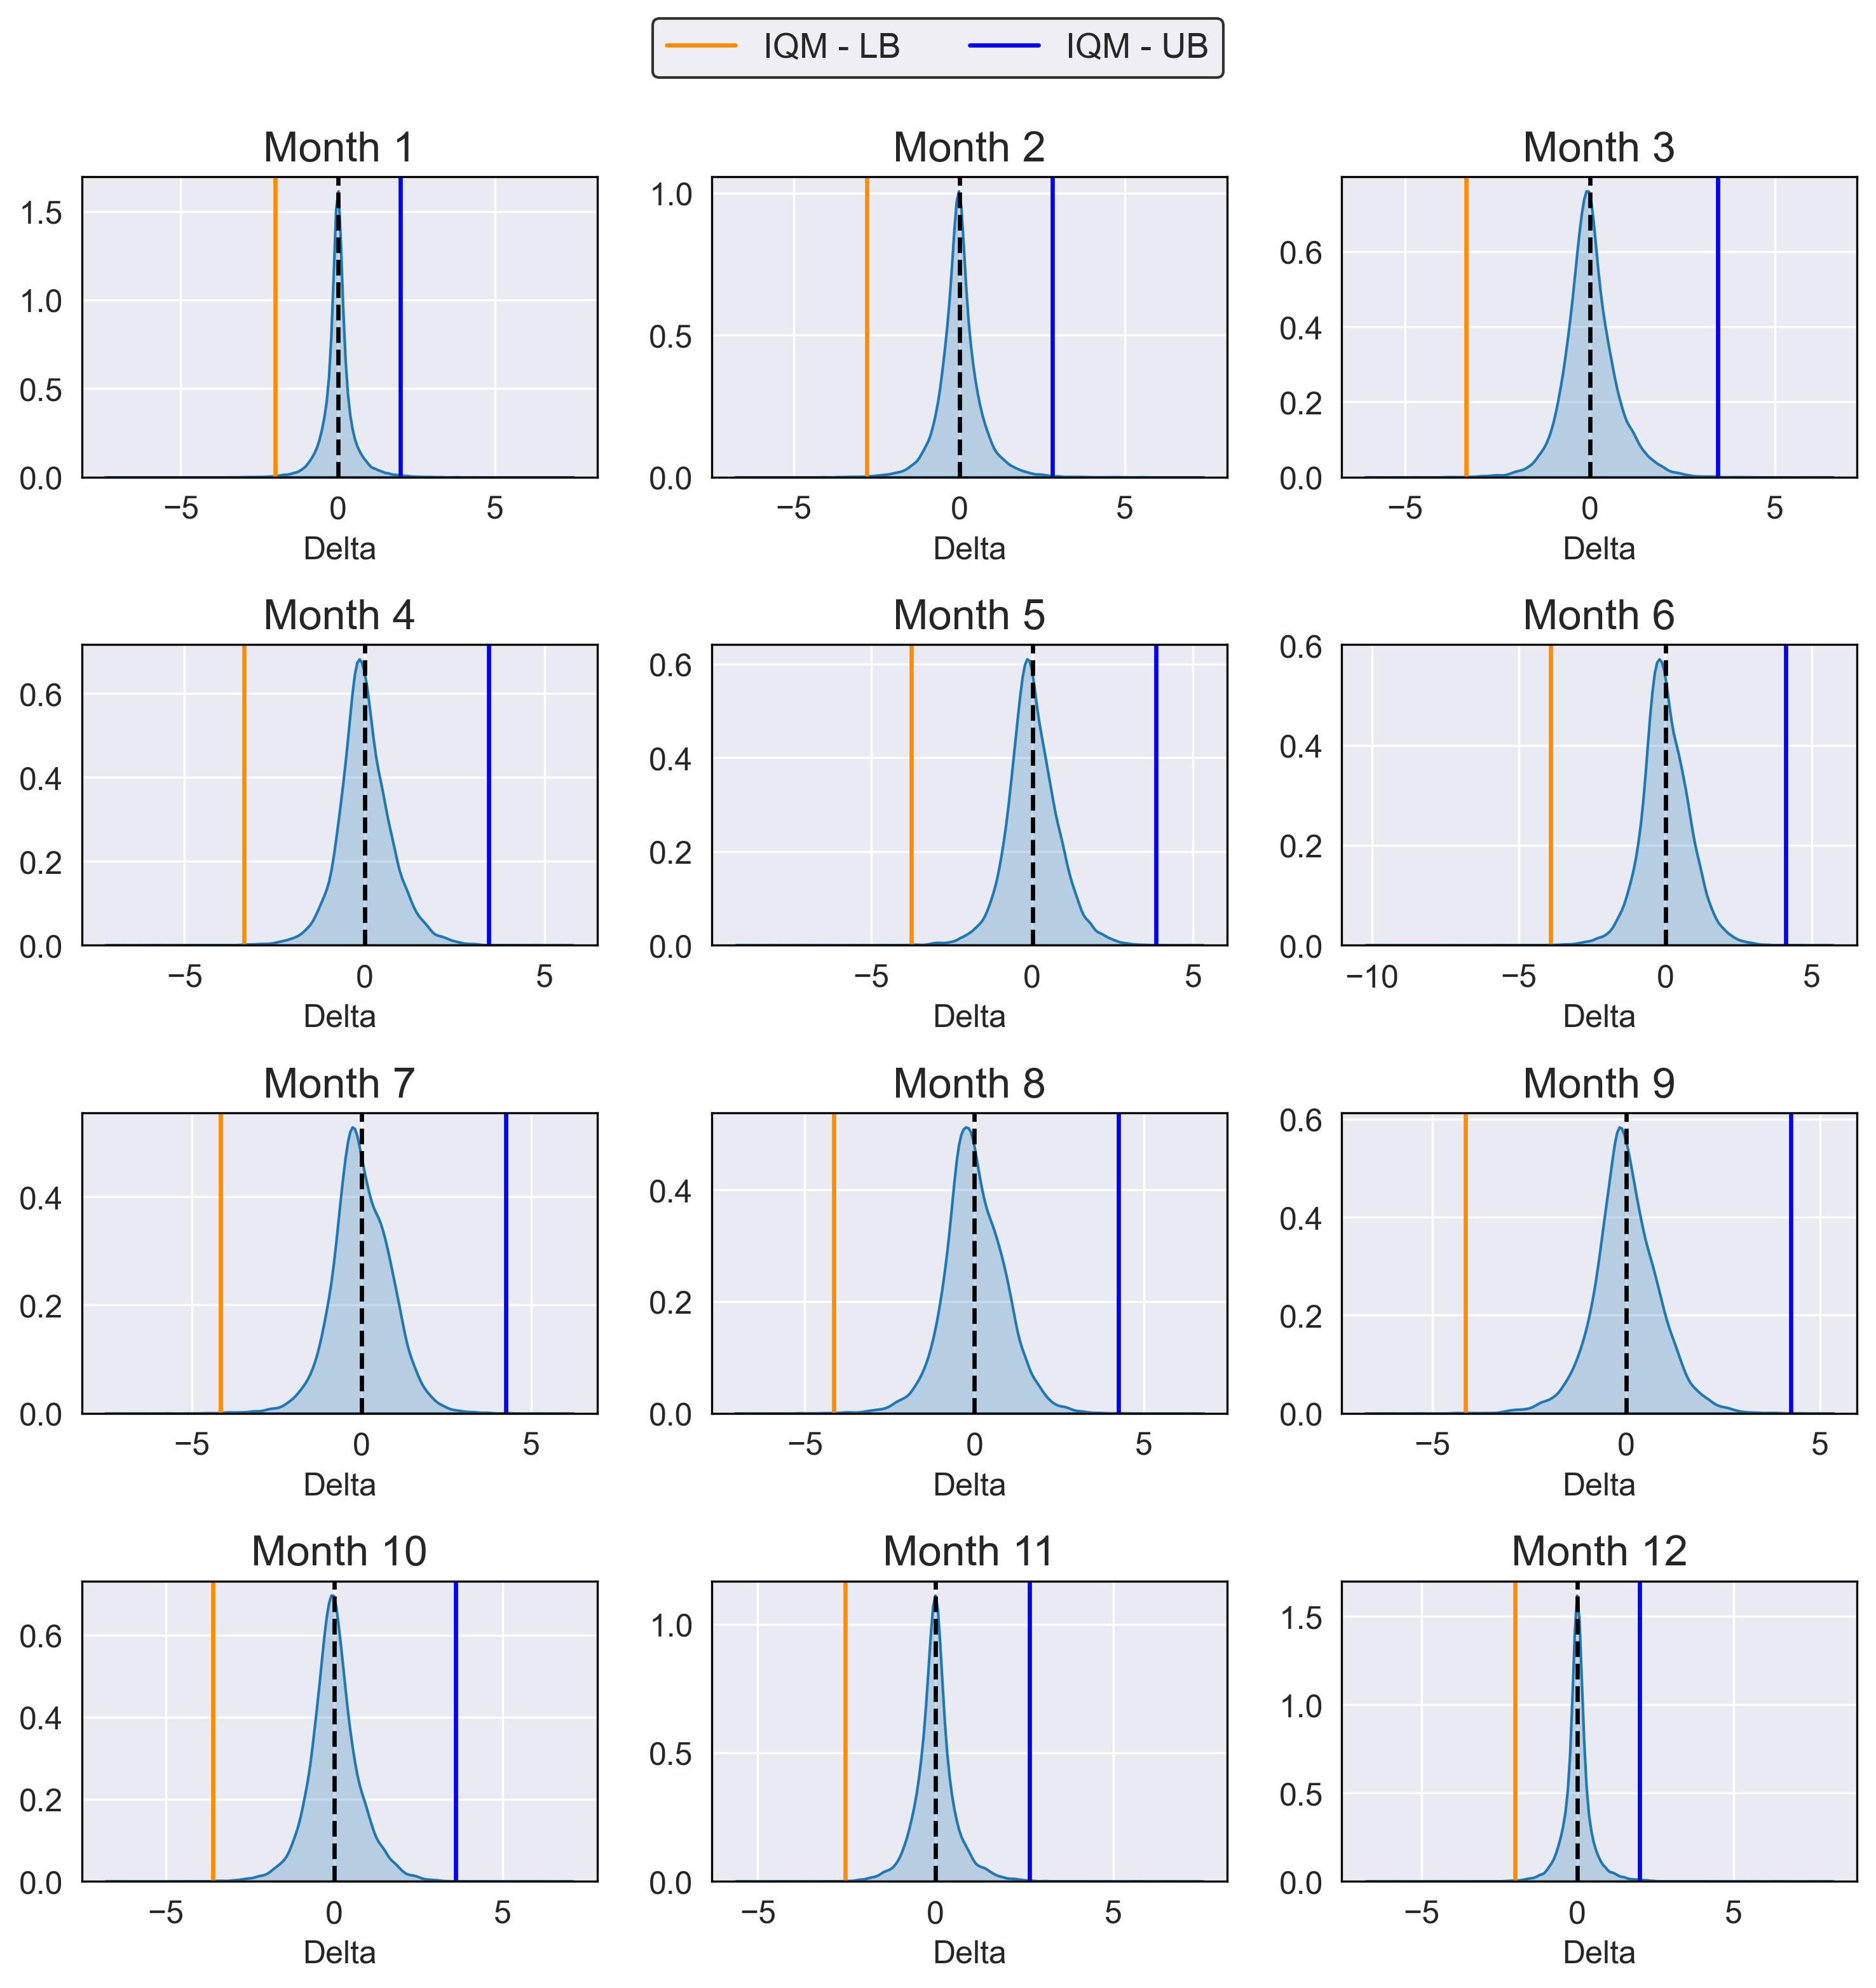

In [16]:
m_var = {} 

for m in s_tmp.month.unique(): # iterate over each month
    tmp = s_tmp[s_tmp.month == m] # subset single month
    tmp = tmp.drop(columns=['month']) # drop column
    m_var[m] = tmp.diff(axis=1).values.flatten() # get all temp changes
    #lb = np.nanquantile(d, 1-q_val) # get lower bound
    #ub = np.nanquantile(d, q_val) # get upper bound
    #m_var[m] = [x for x in d if (lb <= x <= ub)] # subset var to filter extreme values

fig, axs = plt.subplots(4, 3, figsize=(10,10))
axs = axs.flatten()

for m in range(1, 13): # Plot each month
    sns.kdeplot(m_var[m], fill=True, ax=axs[m-1])
    axs[m-1].set_title(f'Month {m}')
    axs[m-1].set_xlabel('Delta')
    axs[m-1].set_ylabel('')
    
    # Plot estimated bounds (quantile filter)
    #b = m_est.iloc[m-1,:].values
    #axs[m-1].axvline(b[0], color='red', linestyle='--', linewidth=1.6, label = 'QF - LB')
    #axs[m-1].axvline(b[1], color='green', linestyle='--', linewidth=1.6, label = 'QF - UB')
    
    # Plot estimated bounds (iqr method)
    b = iqr_est.iloc[m-1,:].values
    axs[m-1].axvline(b[0], color='darkorange', linestyle='-', linewidth=1.6, label = 'IQM - LB')
    axs[m-1].axvline(b[1], color='blue', linestyle='-', linewidth=1.6, label = 'IQM - UB')
    
    # Plot estimated bounds (bootstrap method)
    #b = bs_est.iloc[m-1,:].values
    #axs[m-1].axvline(b[0], color='darkviolet', linestyle='-.', linewidth=1.6, label = 'BS - LB')
    #axs[m-1].axvline(b[1], color='dodgerblue', linestyle='-.', linewidth=1.6, label = 'BS - UB')
    
    # Plot average
    axs[m-1].axvline(np.nanmean(m_var[m]), color='black', linestyle='--', linewidth=1.6)
    
h, l = axs[1].get_legend_handles_labels()
    
fig.legend(h, l, loc='upper center', bbox_to_anchor=(0.5, 1.05), fancybox=True, ncol=6)
plt.tight_layout()
plt.show()

- Looking at the density plots, they do appear normally distributed (mostly). Cold months seem to follow the correct pattern, but warm months begin to slightly right skew (still mostly normal). This will need to be checked with other weather stations, but if this holds then we could use confidence intervals.

### Validation Data Testing

In [29]:
s_tmp_v = s_pivot_v.copy() # create copy (don't alter original)

s_tmp_v['month'] = [int(x.split('-')[1]) for x in s_tmp_v.index.values] # create month column

d = pd.DataFrame(columns=['Month', 'LB_EST', 'UB_EST', 'LB_FLAGS', 'UB_FLAGS'])

for i in s_tmp_v.month.unique():
    v = s_tmp_v[s_tmp_v.month == i] # subset single month
    v = v.drop(columns=['month']).diff(axis=1).values.flatten() # drop column & get deltas
    b = iqr_est.iloc[i-1,:].values
    lb_f = sum(v < b[0])
    ub_f = sum(v > b[1])
    d.loc[i-1] = [i, b[0], b[1], lb_f, ub_f]

d

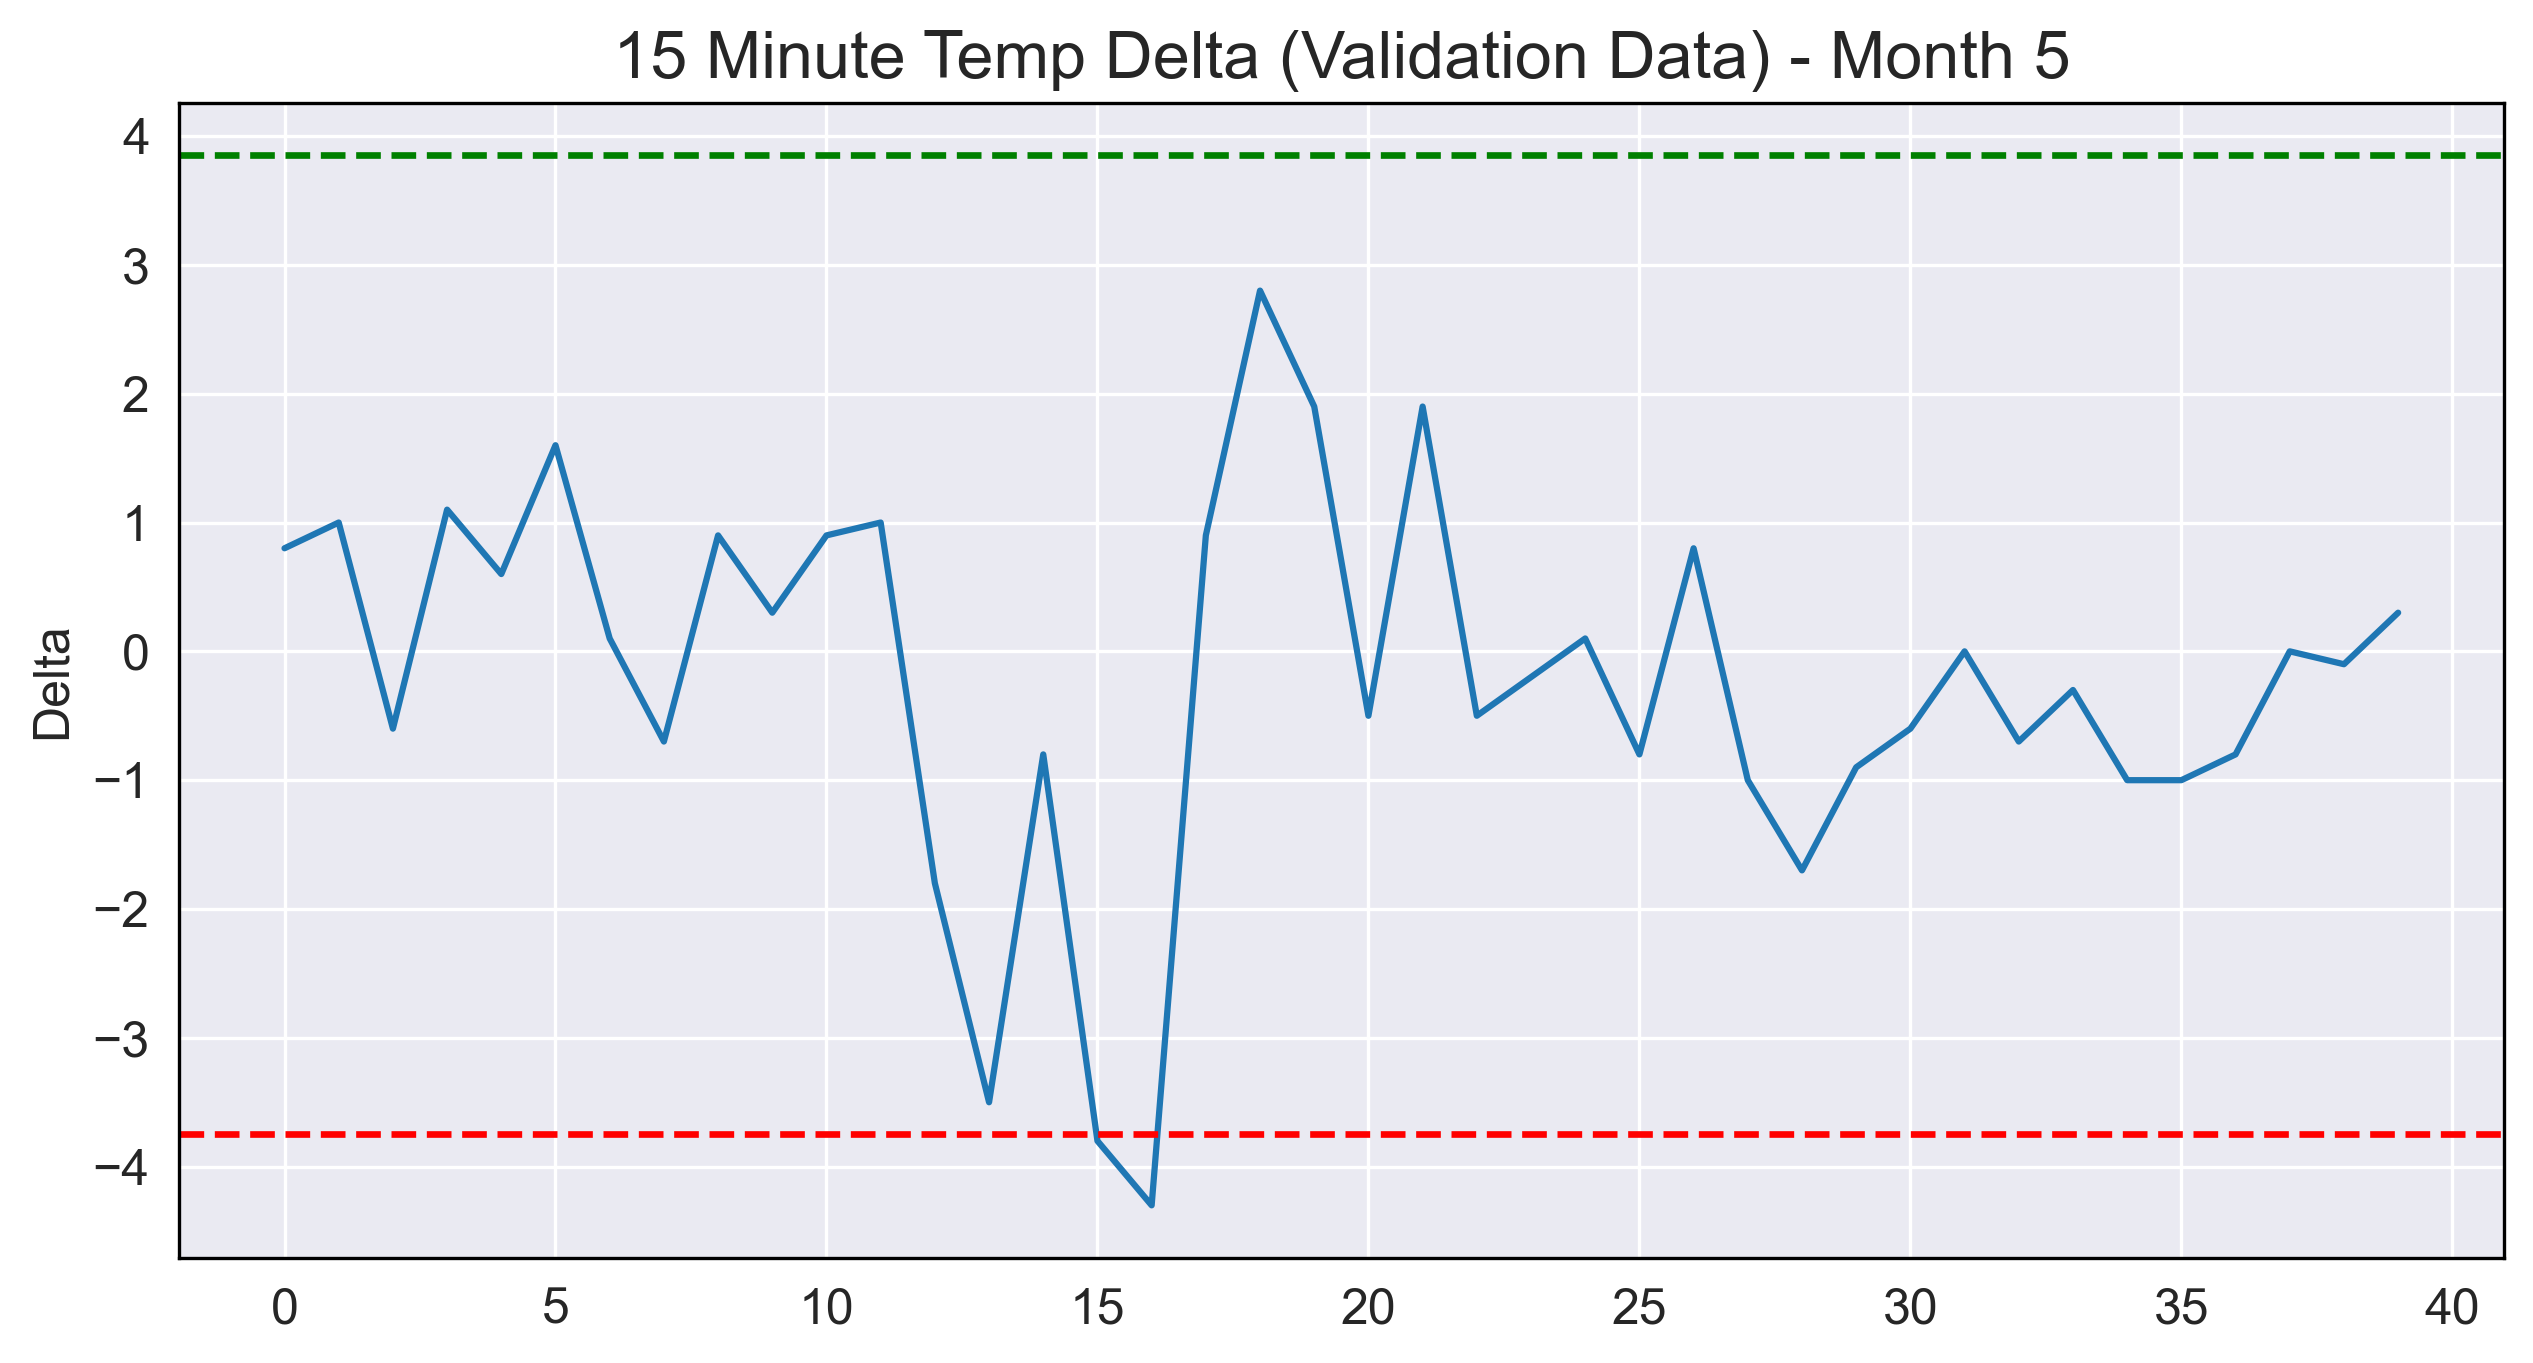

In [20]:
plt.figure(figsize=(10,5))

month = 5

v = s_tmp_v[s_tmp_v.month == month] # subset single month of validation data
v = v.drop(columns=['month']).diff(axis=1).values.flatten() # drop column & get deltas
b = iqr_est.iloc[month-1,:].values # get delta estimates
#b = m_est.iloc[month-1,:].values # get delta estimates
#b = bs_est.iloc[month-1,:].values # get delta estimates

plt.plot(v[2440:2480])
plt.axhline(b[0], color='red', linestyle='--', linewidth=1.6)
plt.axhline(b[1], color='green', linestyle='--', linewidth=1.6)

plt.title(f'15 Minute Temp Delta (Validation Data) - Month {month}')
plt.ylabel('Delta')

plt.show();

### Month Hourly Analysis

To better understand the variance, we want to look at a single month to see how it changes across all days. Each value will be an hourly variance, since plotting 96 values is a bit too crowded for the graph. The patterns we would expect is larger positive delta during sunrise, and larger negative delta during sunset. Similarly, based on the density plots of the above variance, we would expect summer months to see larger ranges and winter months to see smaller ranges. We can do this by making a boxplot for each hour, saying that "during a given hour, we see **x** delta in temperature across all days during the month". Boxplot provides the following insight:

- Center box is the IQR: data between q1 and q3 (middle 50% of the data).
- Values above center box and below line are q3 to max (excluding outliers).
- Values below center box and above line are q1 to min (excluding outliers).
- All diamond points are outliers for that hour (this will help to identify thresholds for variance).

In [218]:
s_tmp = s_pivot_e.copy() # create copy

months = ['-01-', "-07-"]

m1 = [idx for idx, s in enumerate(s_tmp.index.values) if (months[0] in s)] # get all data (2014-2022)
m2 = [idx for idx, s in enumerate(s_tmp.index.values) if (months[1] in s)] # get all data (2014-2022)
m1_tmp = s_tmp.iloc[m1, :] # subset data (month 1)
m2_tmp = s_tmp.iloc[m2, :] # subset data (month 2)

In [28]:
m1_change = pd.DataFrame(columns=np.arange(1,24)) # empty dataframe for each hour
m2_change = pd.DataFrame(columns=np.arange(1,24)) # empty dataframe for each hour

for h, i in enumerate(range(0, 96, 4)): # iterate over each hour (4 readings)
    m1_change[h+1] = m1_tmp.iloc[:, [i,min(i+4, 95)]].diff(axis=1).iloc[:, 1].values # take difference
    m2_change[h+1] = m2_tmp.iloc[:, [i,min(i+4, 95)]].diff(axis=1).iloc[:, 1].values # take difference

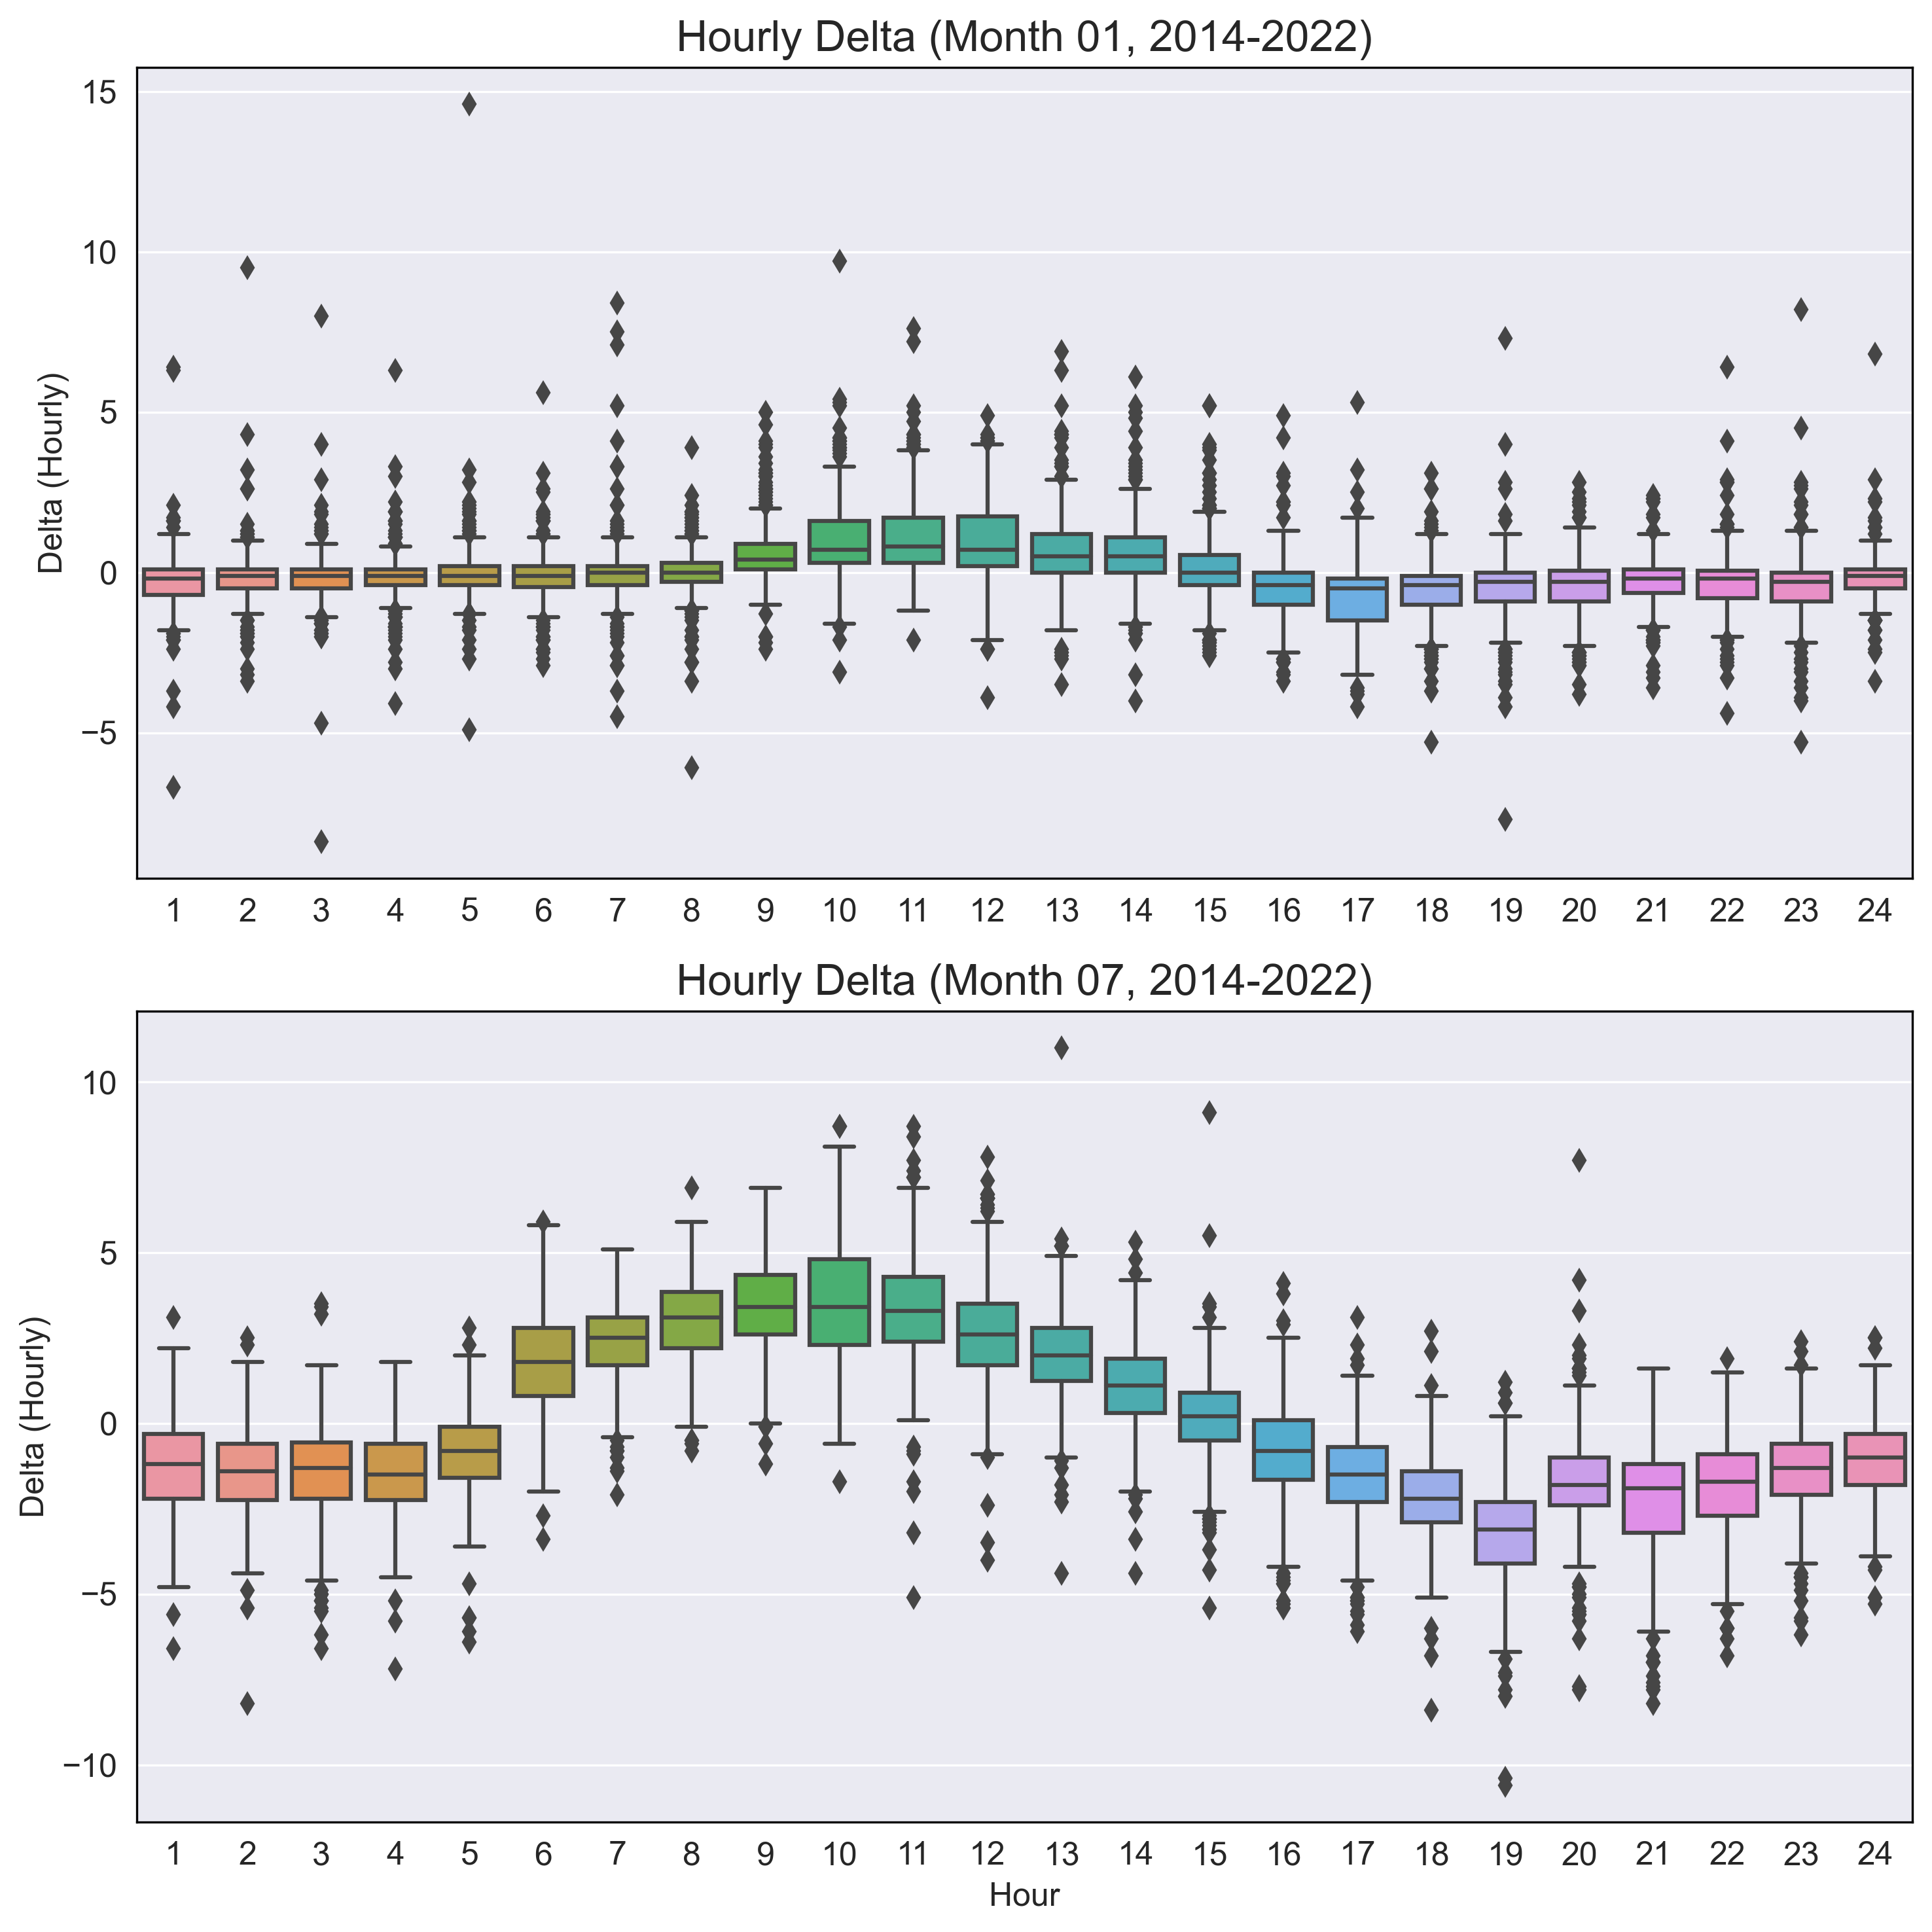

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs = axs.flatten()

for i, d in enumerate([m1_change, m2_change]):
    title = months[i][1:3]
    sns.boxplot(data=d, ax=axs[i])
    axs[i].set_ylabel('Delta (Hourly)')
    axs[i].set_title(f'Hourly Delta (Month {title}, 2014-2022)')
    
axs[1].set_xlabel('Hour')
plt.tight_layout()
plt.show();